Academic Integrity and Learning Statement

By submitting my work, I confirm that:

1. The code, analysis, and documentation in this notebook are my own work and reflect my own understanding.
2. I am prepared to explain all code and analysis included in this submission.

If I used assistance (e.g., AI tools, tutors, or other resources), I have:

- Clearly documented where and how external tools or resources were used in my solution.
- Included a copy of the interaction (e.g., AI conversation or tutoring notes) in an appendix.

I acknowledge that:

- I may be asked to explain any part of my code or analysis during evaluation.
- Misrepresenting assisted work as my own constitutes academic dishonesty and undermines my learning.

In [20]:
import numpy as np
import os
import pandas as pd
import multiprocessing
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import mlflow
import tensorflow as tf
import torch
import platform

In [3]:
# Enable auto-reload extension
%load_ext autoreload
# Automatically reload all modules before executing code
%autoreload 2

In [6]:
import base_utils_logging
import proj_utils_data_loader
import proj_configs
import proj_utils
import proj_utils_feat_engg
import proj_utils_plots
import proj_utils_model

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [21]:
# Check software specs
dict_sw_version = {
    'python': os.popen('python --version').read().strip(),
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'optuna': optuna.__version__,
    'mlflow': mlflow.__version__,
}

for key, value in dict_sw_version.items():
    print(f'{proj_utils_plots.beautify(key, 1)} version is: {proj_utils_plots.beautify(value)}')


python version is: Python 3.11.13
numpy version is: 2.0.0
pandas version is: 2.2.3
optuna version is: 4.4.0
mlflow version is: 2.18.0


In [28]:
# Check hardware specs
def get_mac_gpu_info():
    try:
        # Get system information about GPU
        result = subprocess.run(['system_profiler', 'SPDisplaysDataType'],
                              capture_output=True, text=True)
        return result.stdout
    except Exception as e:
        return f"Error getting GPU info: {e}"

# Check CPU cores
print(f'CPU cores available to use: {proj_utils_plots.beautify(str(multiprocessing.cpu_count()))}')

# Check MPS availability
print("TensorFlow GPU devices:", proj_utils_plots.beautify(tf.config.list_physical_devices('GPU')))
print(f"Processor: {proj_utils_plots.beautify(platform.processor())}")
print(f"Machine: {proj_utils_plots.beautify(platform.machine())}")

print("PyTorch MPS (Metal) Status:")
print(f"MPS available: {proj_utils_plots.beautify(torch.backends.mps.is_available())}")
print(f"MPS built: {proj_utils_plots.beautify(str(torch.backends.mps.is_built()))}")

# Get detailed GPU information
print("\nDetailed GPU Information:")
print(get_mac_gpu_info())

CPU cores available to use: 10
TensorFlow GPU devices: []
Processor: arm
Machine: arm64
PyTorch MPS (Metal) Status:
MPS available: True
MPS built: True

Detailed GPU Information:
Graphics/Displays:

    Apple M4:

      Chipset Model: Apple M4
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 10
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        DELL U3425WE:
          Resolution: 3440 x 1440 (UWQHD - Ultra-Wide Quad HD)
          UI Looks like: 3440 x 1440 @ 100.00Hz
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Rotation: Supported




In [29]:
base_utils_logging.setup_logging()

In [30]:
base_utils_logging.logger.info('Starting the application')

In [20]:
df_raw = proj_utils_data_loader.load_data(proj_configs.TRAIN_FILE)

In [21]:
df_raw.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
765,766,20,RL,75.0,14587,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,264132
138,139,60,RL,73.0,9066,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,12,2008,WD,Normal,230000
585,586,20,RL,88.0,11443,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2006,New,Partial,369900


In [23]:
df_raw = proj_utils_data_loader.refactor_col_names(df_raw)

In [44]:
# TODO: uncomment and comment below insignificant col list
# insignificant_cols = ['Order', 'PID']
insignificant_cols = ['Id']
target_col = 'SalePrice'
ignorables_cols = insignificant_cols + [target_col]
ordinal_cols = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
temporal_cols_name_pattern = ['Yr', 'Year']

In [25]:
n_cat_cardinality_threshold = proj_configs.CATEGORICAL_CARDINALITY_THRESHOLD_ABS
threshold_type = 'ABS'
feature_categories = proj_utils_feat_engg.classify_columns(df=df_raw, n_cat_threshold=n_cat_cardinality_threshold, threshold_type=threshold_type, cols_to_ignore=ignorables_cols, temporal_cols_name_pattern=temporal_cols_name_pattern, ordinal_cols=ordinal_cols)

In [26]:
cols_num_continuous, n_num_continuous, cols_num_discrete, n_num_discrete, cols_cat_nominal, n_cat_nominal, cols_cat_ordinal, n_cat_ordinal, cols_object, n_object, cols_temporal, n_temporal, cols_binary, n_binary = proj_utils_feat_engg.get_cols_as_tuple(feature_categories)

n_total = df_raw.shape[1] - len(ignorables_cols)

print(f'='*80)
print(f'Total raw columns = {proj_utils_plots.beautify(len(df_raw.columns))} \nNumerical Continuous = {proj_utils_plots.beautify(n_num_continuous)} \nNumerical Discrete = {proj_utils_plots.beautify(n_num_discrete)} \nCategorical Nominal = {proj_utils_plots.beautify(n_cat_nominal)} \nCategorical Ordinal = {proj_utils_plots.beautify(n_cat_ordinal)} \nObject/String = {proj_utils_plots.beautify(n_object)} \nTemporal = {proj_utils_plots.beautify(n_temporal)} \nBinary = {proj_utils_plots.beautify(n_binary)}')

print(f'='*80)
print(f'Any inconsistencies detected?[True/False] = {proj_utils_plots.beautify("True", 3) if n_total != len(df_raw.columns) - len(ignorables_cols) else proj_utils_plots.beautify("False", 1)}')
print(f'='*80)

Total raw columns = 81 
Numerical Continuous = 17 
Numerical Discrete = 13 
Categorical Nominal = 17 
Categorical Ordinal = 18 
Object/String = 7 
Temporal = 4 
Binary = 3
Any inconsistencies detected?[True/False] = False


In [27]:
# Calculate the number of NaN values for each column
nan_counts = df_raw.isna().sum()

# Filter only columns that have NaN values and sort by the number of NaNs
cols_with_nans = nan_counts[nan_counts > 0].index.tolist()
print(f'Columns with NaNs: = {proj_utils_plots.beautify(len(cols_with_nans))}/{proj_utils_plots.beautify(n_total)}')
print(f'And they are: {cols_with_nans}')

Columns with NaNs: = 19/77
And they are: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [28]:
df_cardinality = proj_utils_feat_engg.get_cardinality_df(df_raw)

In [29]:
df_cardinality

,col_name,notnull_pct,null_pct,unique_pct
Id,Id,1.000,0.000,1.000
MSSubClass,MSSubClass,1.000,0.000,0.010
MSZoning,MSZoning,1.000,0.000,0.003
LotFrontage,LotFrontage,0.823,0.177,0.075
LotArea,LotArea,1.000,0.000,0.735
...,...,...,...,...
MoSold,MoSold,1.000,0.000,0.008
YrSold,YrSold,1.000,0.000,0.003
SaleType,SaleType,1.000,0.000,0.006
SaleCondition,SaleCondition,1.000,0.000,0.004


In [30]:
proj_utils_plots.plot_cardinality(df_cardinality, n_cat_cardinality_threshold, threshold_used=threshold_type, type_of_cols='all', figsize=(20, 6))

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cardinality_all_20250624_113343_191.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cardinality_all_20250624_113343_191.png

In [31]:
# Zoom into cols having NaNs only
proj_utils_plots.plot_cardinality(df_cardinality[df_cardinality['col_name'].isin(cols_with_nans)], n_cat_cardinality_threshold, threshold_used=threshold_type, type_of_cols="NaN", figsize=(10, 6))

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cardinality_NaN_20250624_113348_876.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cardinality_NaN_20250624_113348_876.png

In [32]:
df_raw[cols_num_continuous].isnull().sum().sort_values(ascending=False)

LotFrontage      259
MasVnrArea         8
LowQualFinSF       0
ScreenPorch        0
EnclosedPorch      0
OpenPorchSF        0
WoodDeckSF         0
GarageArea         0
GrLivArea          0
2ndFlrSF           0
LotArea            0
1stFlrSF           0
TotalBsmtSF        0
BsmtUnfSF          0
BsmtFinSF2         0
BsmtFinSF1         0
MiscVal            0
dtype: int64

In [33]:
# Creating a copy of the raw data to impute missing values for plotting purposes only (as NaNs are not plotted)
df_imputed_for_plots = df_raw.copy()
df_imputed_for_plots[cols_num_continuous] = df_imputed_for_plots[cols_num_continuous].fillna(0)
most_frequent = df_imputed_for_plots[cols_num_discrete].mode().iloc[0]
df_imputed_for_plots[cols_num_discrete] = df_imputed_for_plots[cols_num_discrete].fillna(most_frequent)

In [34]:
df_imputed_for_plots

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [35]:
df_imputed_for_plots_v2 = df_raw[cols_num_continuous+['SalePrice']].copy()

In [36]:
df_imputed_for_plots_v2.sample(2)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,SalePrice
543,34.0,4058,182.0,584,139,0,723,767,0,0,767,367,120,40,0,0,0,133000
799,60.0,7200,252.0,569,0,162,731,981,787,0,1768,240,0,0,264,0,0,175000


In [37]:
# correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")
correlation_plot = proj_utils_plots.plot_correlation_with_target(df_imputed_for_plots_v2, target_col)

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_corr_with_SalePrice_20250624_113408_366.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_corr_with_SalePrice_20250624_113408_366.png

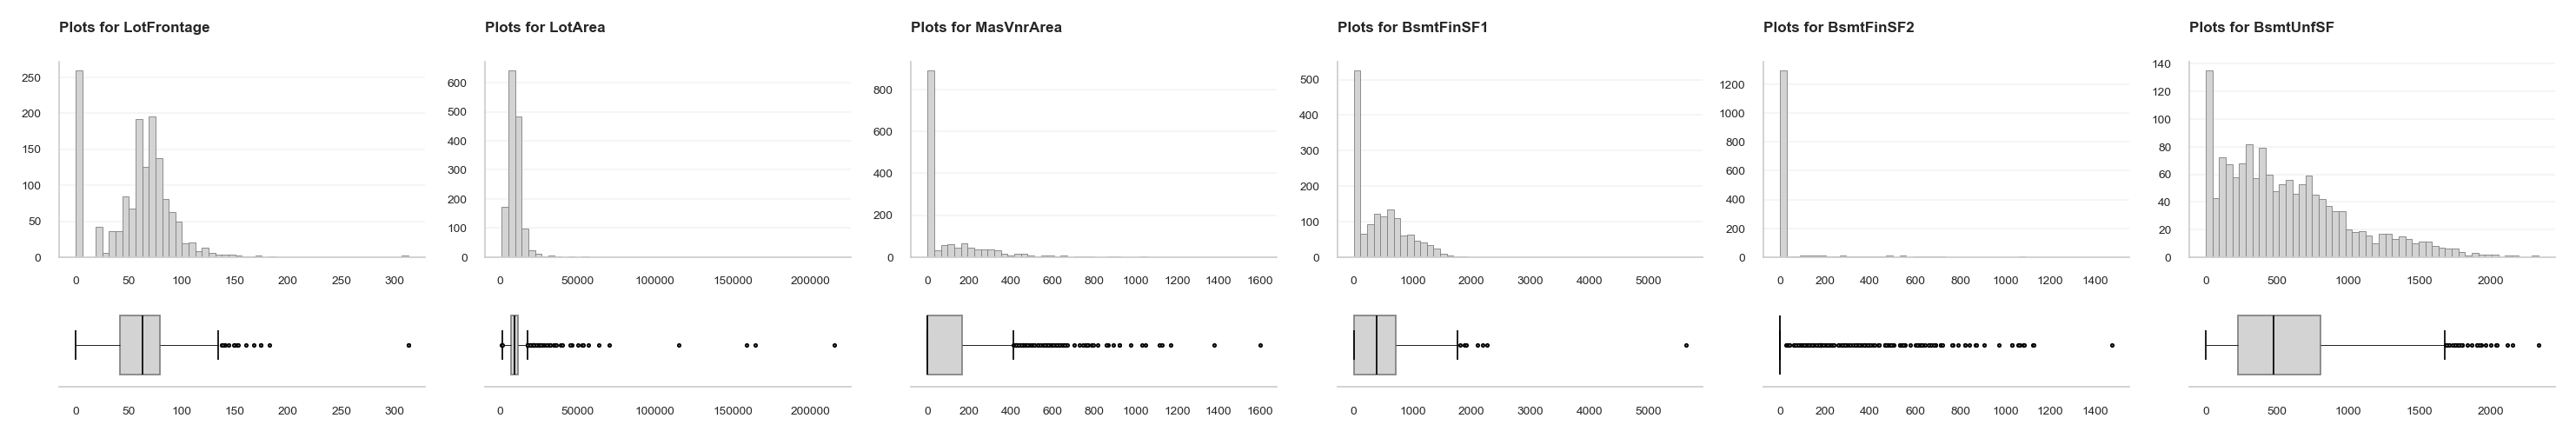

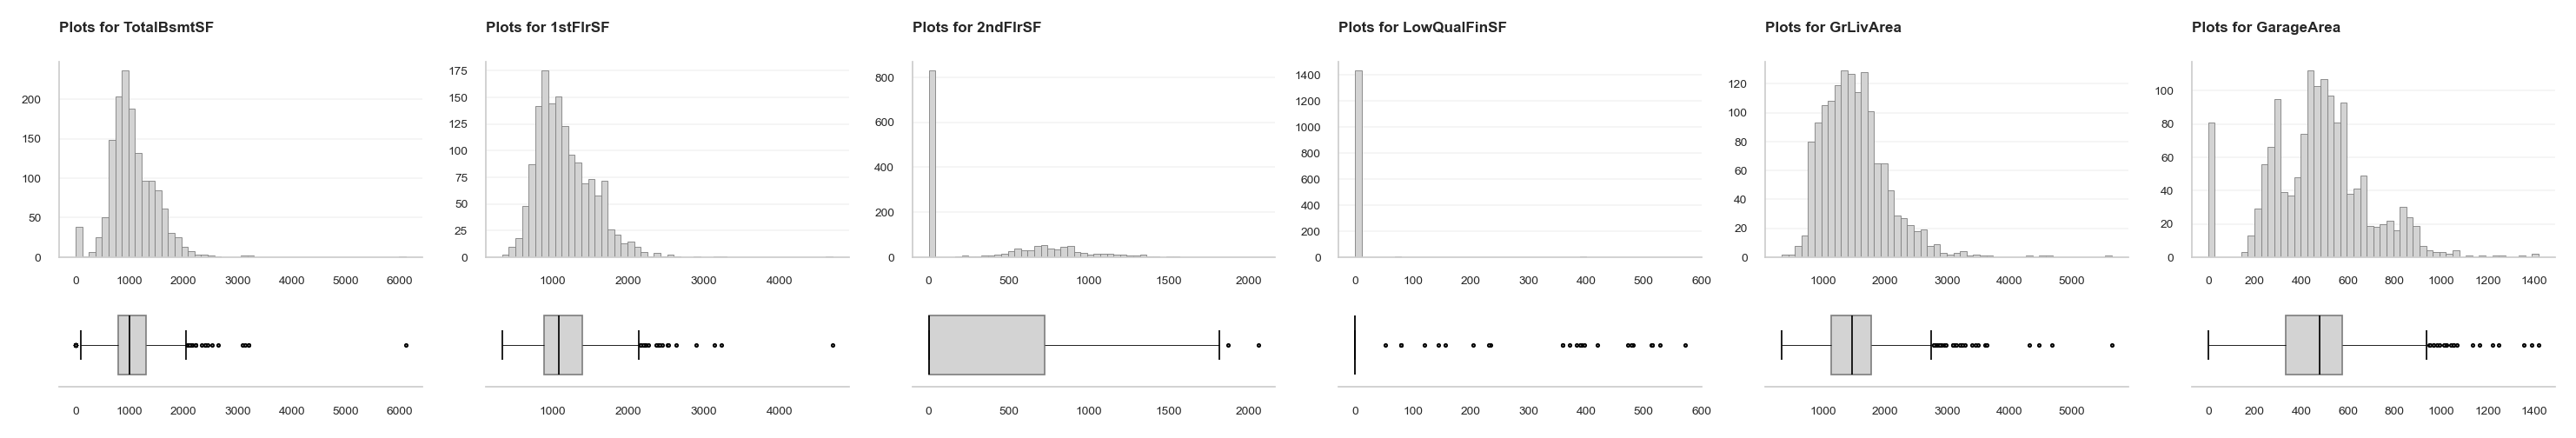

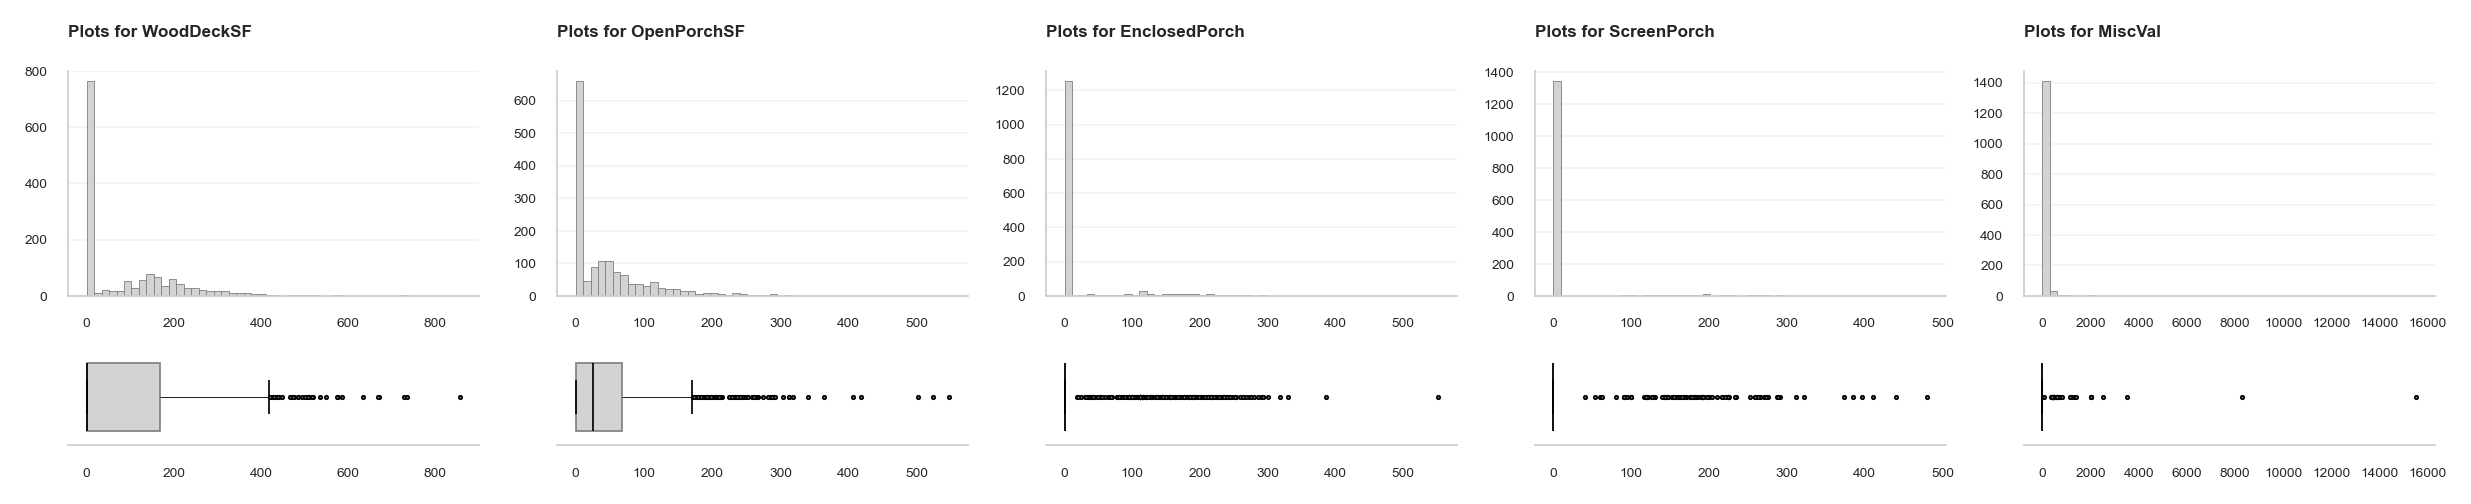

In [38]:
proj_utils_plots.plot_numerical_distribution(df_imputed_for_plots, cols_num_continuous)

In [39]:
proj_utils_plots.plot_categorical_distribution(df_imputed_for_plots, cols_cat_nominal)

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cat_distro_17feats_20250624_113414_872.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cat_distro_17feats_20250624_113414_872.png

In [40]:
proj_utils_plots.plot_categorical_distribution(df_imputed_for_plots, cols_cat_ordinal)

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cat_distro_18feats_20250624_113416_694.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_cat_distro_18feats_20250624_113416_694.png

In [41]:
proj_utils_plots.plot_relationship_to_target(df_imputed_for_plots, cols_num_discrete, target_col)

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_relate_13feats_to_target_SalePrice_20250624_113423_899.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_relate_13feats_to_target_SalePrice_20250624_113423_899.png

In [42]:
proj_utils_plots.plot_relationship_to_target(df_imputed_for_plots, cols_num_discrete, target_col, trend_type='median')

Saving figure to D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_relate_13feats_to_target_SalePrice_20250624_113427_078.png


D:\workbench\pycharm\epfl-adsml-c3-01\plots\plot_relate_13feats_to_target_SalePrice_20250624_113427_078.png

In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    df_raw.drop(ignorables_cols, axis=1),
    df_raw[target_col],
    test_size=proj_configs.VALIDATION_SIZE,
    random_state=proj_configs.RANDOM_STATE
)

In [45]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1168, 79), (1168,), (292, 79), (292,))

In [46]:
num_columns = cols_num_continuous
cat_columns = cols_cat_nominal + cols_cat_ordinal + cols_num_discrete + cols_binary + cols_object
tempo_columns = cols_temporal

In [47]:
len(num_columns), len(cat_columns), len(tempo_columns)

(17, 58, 4)

In [48]:
pproc_pipe = proj_utils_feat_engg.create_pproc_pipeline(num_columns, cat_columns, tempo_columns)

In [49]:
mlflow.login()

2025/06/24 11:39:05 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://dbc-3841cce1-a3be.cloud.databricks.com.


In [50]:
# proj_utils_model.set_mlflow_uri('http://127.0.0.1:8080')
proj_utils_model.set_mlflow_uri("databricks")

In [51]:
mlflow_experiment_name = f"/Users/asheesh.ambardar@live.com/{proj_configs.PROJECT_NAME}"
mlflow_experiment_id = proj_utils_model.get_or_create_experiment(mlflow_experiment_name)

In [52]:
mlflow_experiment_id

'1539464224853128'

In [53]:
proj_utils_model.set_mlflow_experiment(mlflow_experiment_name)

In [54]:
import warnings, logging
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
logging.getLogger("mlflow").setLevel(logging.ERROR)

In [55]:
X_train_transformed = pproc_pipe.fit_transform(X_train)

In [56]:
X_val_transformed = pproc_pipe.transform(X_val)

In [57]:
y_train_transformed = y_train.to_numpy()
y_val_transformed = y_val.to_numpy()

In [58]:
# Check for both NaN and None
has_nulls_or_nans = pd.isna(X_train_transformed).any()
print(f"Contains null or NaN values: {has_nulls_or_nans}")

Contains null or NaN values: False


In [59]:
type(y_val)

pandas.core.series.Series

In [ ]:
run_name='lasso-03'
artefact_path = 'artefact_path'
optimised_study_lasso = proj_utils_model.run_hyperparam_tuning_lasso(X_train, y_train, X_val, y_val, pproc_pipe, mlflow_experiment_id, run_name, artefact_path, proj_configs.OPTUNA_TRIAL_COUNT)

In [61]:
run_name='xgb-02'
artefact_path = 'artefact_path'
optimised_study_xgb = proj_utils_model.run_hyperparam_tuning_xgb(X_train_transformed, y_train_transformed, X_val_transformed, y_val_transformed, mlflow_experiment_id, run_name, artefact_path, proj_configs.OPTUNA_TRIAL_COUNT)

🏃 View run treasured-sow-342 at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128/runs/a331ebf45ce046428bca49e42bff0baa
🧪 View experiment at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128
Trial 0 achieved value: 2114580267.112493 with no improvement
Initial trial 0 achieved value: 2114580267.112493
🏃 View run delicate-eel-256 at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128/runs/10fa50b3daef41e88f35614e6a4eaa9c
🧪 View experiment at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128
🏃 View run loud-worm-855 at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128/runs/a1ff3e4aeb8e481aabe6d2b2077c93c4
🧪 View experiment at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128
🏃 View run sedate-ox-188 at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128/runs/47d4634123324ba7aed5188b6f4

Uploading artifacts:   0%|          | 0/7 [00:00<?, ?it/s]

🏃 View run xgb-02 at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128/runs/d72a53fe0a31467084ebeaceb1edc48e
🧪 View experiment at: https://dbc-3841cce1-a3be.cloud.databricks.com/ml/experiments/1539464224853128


In [ ]:
run_name='rfc-05'
artefact_path = 'artefact_path'
optimised_study_rfc = proj_utils_model.run_hyperparam_tuning_rfc(X_train, y_train, X_val, y_val, pproc_pipe, mlflow_experiment_id, run_name, artefact_path, proj_configs.OPTUNA_TRIAL_COUNT)

In [67]:
model_uri = mlflow.get_artifact_uri(artefact_path)
model_uri

'dbfs:/databricks/mlflow-tracking/1539464224853128/422cd3fff065487580dc5fa8bb710ab7/artifacts/artefact_path'

In [68]:
loaded_model = mlflow.sklearn.load_model(
    model_uri="dbfs:/databricks/mlflow-tracking/1539464224853128/d72a53fe0a31467084ebeaceb1edc48e/artifacts/artefact_path"
)

In [69]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7222694529343134, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0878038851801299, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
df_raw_test = proj_utils_data_loader.load_data(proj_configs.TEST_FILE)

In [94]:
df_test = proj_utils_data_loader.refactor_col_names(df_raw_test)

In [95]:
df_test.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
183,1644,60,FV,NaN,8470,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,...,84,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml
315,1776,20,RL,67.0,13070,Pave,NaN,Reg,Lvl,AllPub,...,255,0,NaN,NaN,NaN,0,10,2009,WD,Normal


In [96]:
df_test.drop(insignificant_cols, axis=1, inplace=True)

In [97]:
data_test_transformed = pproc_pipe.transform(df_test)
type(data_test_transformed)

numpy.ndarray

In [98]:
# Check for both NaN and None
has_nulls_or_nans = pd.isna(df_test_transformed).any()
print(f"Contains null or NaN values: {has_nulls_or_nans}")

Contains null or NaN values: False


In [99]:
df_raw_train = df_raw.copy()
df_raw_train.drop(ignorables_cols, axis=1, inplace=True)

In [100]:
data_train_transformed = pproc_pipe.transform(df_raw_train)
type(data_train_transformed)

numpy.ndarray

In [101]:
# Check for both NaN and None
has_nulls_or_nans = pd.isna(df_train_transformed).any()
print(f"Contains null or NaN values: {has_nulls_or_nans}")

Contains null or NaN values: False


In [102]:
data_target = df_raw[target_col].to_numpy()
type(data_target)

numpy.ndarray

In [103]:
loaded_model.fit(data_train_transformed, data_target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7222694529343134, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0878038851801299, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [104]:
train_preds = loaded_model.predict(data_train_transformed)
train_actuals = data_target

In [105]:
# Evaluate the model
train_mse = mean_squared_error(train_actuals, train_preds).round(5)
train_r2 = r2_score(train_actuals, train_preds).round(5)

print("=== Model Performance ===")
print(f"Train MSE: {proj_utils_plots.beautify(train_mse)}, Train R2: {proj_utils_plots.beautify(train_r2)}")

=== Model Performance ===
Train MSE: 164260119.07401, Train R2: 0.97396


In [106]:
test_preds = loaded_model.predict(data_test_transformed)

In [107]:
test_preds

array([128688.59, 158134.3 , 188172.39, ..., 159990.36, 123831.67,
       228091.72], dtype=float32)

In [108]:
my_submission = pd.DataFrame({'Id': df_raw_test.Id, 'SalePrice': test_preds})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [63]:
# this is a Trial object, not the underlying ML object.
best_performing_trial = optimised_study_xgb.best_trial
print(f'Best trial was at number {proj_utils_plots.beautify(str(best_performing_trial.number), 1)} with params as:\n {proj_utils_plots.beautify(str(best_performing_trial.params), 2)}')
print(f'Best score value is: {proj_utils_plots.beautify(str(best_performing_trial.value))}')

Best trial was at number 78 with params as:
 {'max_depth': 4, 'learning_rate': 0.0878038851801299, 'n_estimators': 100, 'colsample_bytree': 0.7222694529343134}
Best score value is: 718689215.9145412


In [64]:
best_performing_trial

FrozenTrial(number=78, state=1, values=[718689215.9145412], datetime_start=datetime.datetime(2025, 6, 24, 11, 45, 40, 724198), datetime_complete=datetime.datetime(2025, 6, 24, 11, 45, 41, 455691), params={'max_depth': 4, 'learning_rate': 0.0878038851801299, 'n_estimators': 100, 'colsample_bytree': 0.7222694529343134}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=2.0, log=False, low=0.001, step=None), 'n_estimators': IntDistribution(high=100, log=False, low=10, step=1), 'colsample_bytree': FloatDistribution(high=0.9, log=False, low=0.3, step=None)}, trial_id=78, value=None)

In [65]:
study_full_metrics = optimised_study_xgb.trials_dataframe()
# save the metrics to a file
proj_utils_model.save_hyperparams(f'full_metrics_{proj_utils.get_current_timestamp()}.csv', proj_configs.PATH_OUT_MODELS, study_full_metrics)

# peek at the full metrics dataframe
study_full_metrics

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_n_estimators,state
0,0,2.114580e+09,2025-06-24 11:44:34.623699,2025-06-24 11:44:35.147639,0 days 00:00:00.523940,0.444354,1.218524,3,22,COMPLETE
1,1,5.150427e+09,2025-06-24 11:44:35.175605,2025-06-24 11:44:35.802485,0 days 00:00:00.626880,0.624697,1.718416,4,70,COMPLETE
2,2,2.234300e+09,2025-06-24 11:44:35.834979,2025-06-24 11:44:36.343605,0 days 00:00:00.508626,0.781228,1.467763,2,45,COMPLETE
3,3,7.608075e+08,2025-06-24 11:44:36.375264,2025-06-24 11:44:37.171074,0 days 00:00:00.795810,0.432617,0.114713,4,88,COMPLETE
4,4,9.911228e+08,2025-06-24 11:44:37.197988,2025-06-24 11:44:37.731492,0 days 00:00:00.533504,0.805935,0.632877,5,16,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
495,495,1.009582e+10,2025-06-24 11:51:21.764486,2025-06-24 11:51:22.746142,0 days 00:00:00.981656,0.349800,1.838277,7,88,COMPLETE
496,496,4.248828e+09,2025-06-24 11:51:22.792973,2025-06-24 11:51:23.750303,0 days 00:00:00.957330,0.738819,1.674369,6,74,COMPLETE
497,497,1.301865e+09,2025-06-24 11:51:23.782860,2025-06-24 11:51:24.739089,0 days 00:00:00.956229,0.756032,0.865891,7,75,COMPLETE
498,498,1.393551e+09,2025-06-24 11:51:24.777549,2025-06-24 11:51:25.645048,0 days 00:00:00.867499,0.510848,0.733276,9,54,COMPLETE


In [ ]:
# fetch number of trial runs per model type
num_lr_trials = study_full_metrics[study_full_metrics['params_model'] == 'lr'].shape[0]
num_lasso_trials = study_full_metrics[study_full_metrics['params_model'] == 'lasso'].shape[0]
num_ridge_trials = study_full_metrics[study_full_metrics['params_model'] == 'ridge'].shape[0]
num_elasticnet_trials = study_full_metrics[study_full_metrics['params_model'] == 'elasticnet'].shape[0]

print(f'Total trials = {proj_utils_plots.beautify(str(num_lr_trials + num_lasso_trials + num_ridge_trials + num_elasticnet_trials), 1)}\n-- LR trials = {proj_utils_plots.beautify(str(num_lr_trials), 1)}\n-- Lasso trials = {proj_utils_plots.beautify(str(num_lasso_trials), 1)}\n-- Ridge trials = {proj_utils_plots.beautify(str(num_ridge_trials), 1)}\n-- ElasticNet trials = {proj_utils_plots.beautify(str(num_elasticnet_trials), 1)}')

In [ ]:
# retrieve all performance values for each model type studied
grp_by_model_type_val = study_full_metrics.groupby('params_model')['value'].apply(list)
# retrieve the best performing model (use nsmallest if Optuna objective was to minimise,
grp_by_model_type_best_val = study_full_metrics.groupby('params_model')['value'].nsmallest(1)
# display the stats
grp_by_model_type_best_val

In [ ]:
 # grouping Optuna metrics by model type and using idxmax (or idmin) method to find a row with the best model performance (value) for each group
study_best_model_group = study_full_metrics.loc[study_full_metrics.groupby('params_model')['value'].idxmin()]

In [ ]:
study_best_model_group

In [ ]:
# retrieve the trial number of the best model for each model type - the Optuna metrics dataframe index and trial number are the same.
best_lr_trial = study_best_model_group[study_best_model_group['params_model'] == 'lr']['number'].values[0]
best_lasso_trial = study_best_model_group[study_best_model_group['params_model'] == 'lasso']['number'].values[0]
best_ridge_trial = study_best_model_group[study_best_model_group['params_model'] == 'ridge']['number'].values[0]
best_elasticnet_trial = study_best_model_group[study_best_model_group['params_model'] == 'elasticnet']['number'].values[0]

final_pipe_best_lr = models[best_lr_trial]
best_model_lr = final_pipe_best_lr.named_steps['regressor']
final_pipe_best_lasso = models[best_lasso_trial]
best_model_lasso = final_pipe_best_lasso.named_steps['regressor']
final_pipe_best_ridge = models[best_ridge_trial]
best_model_ridge = final_pipe_best_ridge.named_steps['regressor']
final_pipe_best_elasticnet = models[best_elasticnet_trial]
best_model_elasticnet = final_pipe_best_elasticnet.named_steps['regressor']

# retrieve the best model object (amongst all model types evaluated)
final_pipe_best = models[best_performing_trial.number]
best_model = final_pipe_best.named_steps['regressor']

In [ ]:
final_pipe_best

In [ ]:
final_pipe_best.fit(X_train, y_train)

In [ ]:
cols_final_inputs, cols_final_output_features = proj_utils_feat_engg.get_final_features(final_pipe_best, X_train)

In [ ]:
proj_utils_model.save_features(f'pproc_final_input_cols_{len(cols_final_inputs)}_{proj_utils.get_current_timestamp()}.csv', proj_configs.PATH_OUT_FEATURES, pd.DataFrame(cols_final_inputs))
proj_utils_model.save_features(f'pproc_final_output_features_{len(cols_final_output_features)}_{proj_utils.get_current_timestamp()}.csv', proj_configs.PATH_OUT_FEATURES, pd.DataFrame(cols_final_output_features))

In [ ]:
proj_utils_model.save_model(f'final_pipe_{proj_utils.get_current_timestamp()}.pkl', proj_configs.PATH_OUT_MODELS, final_pipe_best)

In [ ]:
y_train_preds = final_pipe_best.predict(X_train)
y_val_preds = final_pipe_best.predict(X_val)

In [ ]:
# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_preds).round(5)
val_mse = mean_squared_error(y_val, y_val_preds).round(5)
train_r2 = r2_score(y_train, y_train_preds).round(5)
val_r2 = r2_score(y_val, y_val_preds).round(5)

print("=== Model Performance ===")
print(f"Train MSE: {proj_utils_plots.beautify(train_mse)}, Train R2: {proj_utils_plots.beautify(train_r2)}")
print(f"Validation MSE: {proj_utils_plots.beautify(val_mse)}, Validation R2: {proj_utils_plots.beautify(val_r2)}")

In [ ]:
string_to_log = f'=== Model Performance === \n Train MSE: {train_mse}, Train R2: {train_r2} \n Validation MSE: {val_mse}, Validation R2: {val_r2}'
proj_utils.save_file('metrics', 'validation_metrics.txt', proj_configs.PATH_OUT_MODELS, string_to_log)